# Twitter sentiment analysis

### Install dependecies

In [128]:
import os
import setuptools.dist
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from absl import logging
import tensorflow_hub as hub
import tensorflow as tf
from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from timeit import default_timer as timer 
from tqdm import tqdm

In [30]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder")

print("Path to model files:", path)

/Users/marcusandersson/Desktop/twitter_sentiment_analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




100%|██████████| 3.11k/3.11k [00:00<00:00, 13.8kB/s]
















100%|██████████| 7.84M/7.84M [00:02<00:00, 3.42MB/s]
100%|██████████| 980M/980M [01:20<00:00, 12.7MB/s]

Path to model files: /Users/marcusandersson/.cache/kagglehub/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2


### Download dataset

In [12]:
# Ensure the Kaggle API credentials are set up
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset_owner = 'jp797498e/twitter-entity-sentiment-analysis'
api.dataset_download_files(dataset_owner, path='/Users/marcusandersson/Desktop/twitter_sentiment_analysis/data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis


### Load data

In [13]:
# Load the data into a pandas DataFrame
path = '/Users/marcusandersson/Desktop/twitter_sentiment_analysis/data'
data_df = pd.read_csv(path + '/twitter_training.csv')
data_validation_df = pd.read_csv(path + '/twitter_validation.csv')

### Data cleaning

In [14]:
data_validation_df.columns = ['tweet_id', 'entity','sentiment','tweet']
data_df.columns = ['tweet_id', 'entity','sentiment','tweet']

# drop the tweet_id and entity columns
data_df = data_df.drop(['tweet_id', 'entity'], axis=1)

# Drop null values
data_df = data_df.dropna()

# Map the sentiment to a numerical value
data_df['sentiment'] = data_df['sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0, 'Irrelevant': 3})


# Ensure all data typres are correct
data_df['tweet'] = data_df['tweet'].astype(str)
data_df['sentiment'] = data_df['sentiment'].astype(int)

# Check the data
print(data_df.head())

   sentiment                                              tweet
0          2  I am coming to the borders and I will kill you...
1          2  im getting on borderlands and i will kill you ...
2          2  im coming on borderlands and i will murder you...
3          2  im getting on borderlands 2 and i will murder ...
4          2  im getting into borderlands and i can murder y...


### Train test split

In [84]:
# Train test split
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Convert to NumPy arrays
X_train_df = train_df['tweet'].values
y_train_df = train_df['sentiment'].values


X_test_df = test_df['tweet'].values
y_test_df = test_df['sentiment'].values


# Check the data
print(f'Shape of training data input: {X_train.shape}')
print(f'Shape of training data targets: {y_train.shape}')
print(f'Shape of test data input: {X_test.shape}')
print(f'Shape of test data targets: {y_test.shape}')

Shape of training data input: torch.Size([59196, 512])
Shape of training data targets: torch.Size([59196])
Shape of test data input: torch.Size([14799, 512])
Shape of test data targets: torch.Size([14799])


### Load Universal Sentence Encoder model

In [31]:
# Load the model
embed = hub.load(path)

### Produce embeddings

In [32]:
# Compute embeddings
X_train_TF= embed(X_train_df)
X_test_TF = embed(X_test_df)

print(f'Shape of training dataset input: {X_train_TF.shape}')
print(f'Data type of training dataset input: {type(X_train_TF)}')

print(f'Shape of test dataset input: {X_test_TF.shape}')
print(f'Data type of test dataset input: {type(X_test_TF)}')

Shape of training dataset input: (59196, 512)
Data type of training dataset input: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape of test dataset input: (14799, 512)
Data type of test dataset input: <class 'tensorflow.python.framework.ops.EagerTensor'>


### Convert to pyTorch tensor

In [36]:
X_train_np = X_train_TF.numpy()
X_test_np = X_test_TF.numpy()

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np)
X_test = torch.tensor(X_test_np)

y_train = y_train_df.clone().detach()
y_test = y_test_df.clone().detach()

# Check the data
print(f'Shape of training dataset input: {X_train.shape}')
print(f'Data type of training dataset input: {type(X_train)}')

print(f'Shape of test dataset input: {X_test.shape}')
print(f'Data type of test dataset input: {type(X_test)}')



Shape of training dataset input: torch.Size([59196, 512])
Data type of training dataset input: <class 'torch.Tensor'>
Shape of test dataset input: torch.Size([14799, 512])
Data type of test dataset input: <class 'torch.Tensor'>


### Accuracy function

In [37]:
def accuracy(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = correct / y_true.size(0)
    return acc

### Training loop function

In [77]:
def train(n_epochs, model, lr, X_train, y_train, X_test, y_test):
    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize arrays to store loss and accuracy
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    train_accuracies = np.zeros(n_epochs)
    test_accuracies = np.zeros(n_epochs)
    epochs = np.zeros(n_epochs)

    ### Training loop
    model.train()
    for epoch in range(n_epochs):
        # Forward pass

        y_logits = model(X_train)
        y_pred = F.softmax(y_logits, dim=0).argmax(dim=1)

        # Compute the loss and accuracy
        train_loss = loss_fn(y_logits, y_train)
        train_acc = accuracy(y_pred, y_train)

        # Store the loss and accuracy
        train_losses[epoch] = train_loss.item()
        train_accuracies[epoch] = train_acc

        # Zero gradients
        optimizer.zero_grad()

        # Bckward pass
        train_loss.backward()

        # Update the weights
        optimizer.step() 

        ### Test loop

        model.eval()

        with torch.inference_mode():
            y_logits = model(X_test)
            y_pred = F.softmax(y_logits, dim=1).argmax(dim=1)

            test_loss = loss_fn(y_logits, y_test)
            test_acc = accuracy(y_pred, y_test)

            # Store the loss and accuracy
            test_losses[epoch] = test_loss.item()
            test_accuracies[epoch] = test_acc
            epochs[epoch] = epoch
        if epoch % 10 == 0:
            print(f'Epoch {epoch}| train loss: {train_loss.item():.4f}, train acc: {train_acc:.4f}| test loss: {test_loss.item():.4f}, test acc: {test_acc:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies, epochs
    
        
    



### Sentiment analysisi model

In [99]:
class SentimentAnalysisModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        #self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(128, 4)

        self.dropout = nn.Dropout(0.2)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        #x = self.fc3(x)
        #x = self.relu(x)
        x = self.fc4(x)

        return x



In [118]:
model = SentimentAnalysisModel()

### Function to plot loss and accuracy

In [101]:
def plot_loss(train_loss, test_loss, epochs):
    plt.plot(epochs, train_loss, label='train loss')
    plt.plot(epochs, test_loss, label='test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Train model

Epoch 0| train loss: 1.3884, train acc: 0.2119| test loss: 1.3862, test acc: 0.3016
Epoch 10| train loss: 1.3666, train acc: 0.5028| test loss: 1.3647, test acc: 0.3016
Epoch 20| train loss: 1.3287, train acc: 0.5127| test loss: 1.3263, test acc: 0.3523
Epoch 30| train loss: 1.2664, train acc: 0.5248| test loss: 1.2652, test acc: 0.4796
Epoch 40| train loss: 1.1868, train acc: 0.5358| test loss: 1.1892, test acc: 0.5217
Epoch 50| train loss: 1.1132, train acc: 0.5434| test loss: 1.1223, test acc: 0.5325
Epoch 60| train loss: 1.0675, train acc: 0.5424| test loss: 1.0833, test acc: 0.5413
Epoch 70| train loss: 1.0402, train acc: 0.5460| test loss: 1.0599, test acc: 0.5548
Epoch 80| train loss: 1.0195, train acc: 0.5493| test loss: 1.0417, test acc: 0.5673
Epoch 90| train loss: 1.0065, train acc: 0.5506| test loss: 1.0302, test acc: 0.5720
Epoch 100| train loss: 0.9968, train acc: 0.5544| test loss: 1.0218, test acc: 0.5769
Epoch 110| train loss: 0.9882, train acc: 0.5598| test loss: 1.01

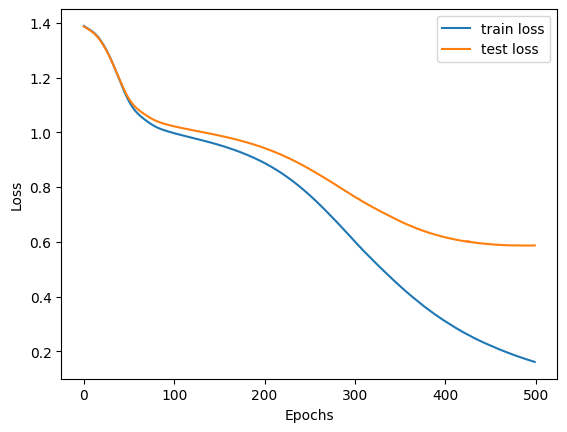

In [119]:
NUM_EPOCHS = 500
LR = 5e-4

train_losses, test_losses, train_accuracies, test_accuracies, epochs = train(NUM_EPOCHS, model, LR, X_train, y_train, X_test, y_test)

plot_loss(train_losses, test_losses, epochs)

### Make some predictions

In [87]:
def sentiment(pred):
    if pred == 0:
        return 'Negative'
    elif pred == 1:
        return 'Neutral'
    elif pred == 2:
        return 'Positive'
    elif pred == 3:
        return 'Irrelevant'

In [120]:
y_logits = model(X_test)
y_pred = F.softmax(y_logits, dim=0).argmax(dim=1)
for i in range(10):
    random_index = np.random.randint(0, X_test.size(0))
    tweet = X_test_df[random_index]
    print(f'Tweet: {tweet[:50]}... | Predicted: {sentiment(y_pred[random_index])}, Actual: {sentiment(y_test[random_index])}')

Tweet: FACTS WHO TALK THAT SHIT SO MUCH THEY DONT NOTICE... | Predicted: Neutral, Actual: Neutral
Tweet: Damn what ps5 ’ s first L bug that I ’ ve seen, I ... | Predicted: Neutral, Actual: Neutral
Tweet: @Battlefield @ea  . Why the story mode is so limit... | Predicted: Neutral, Actual: Neutral
Tweet: When you tell me you don't have a girlfriend but y... | Predicted: Positive, Actual: Positive
Tweet: Imagine, it's a shame @ Beluba @ Ronal2k @ Nba2k..... | Predicted: Negative, Actual: Negative
Tweet: As This was a close class one, really close!. Toni... | Predicted: Irrelevant, Actual: Neutral
Tweet: This is the last time I waste my time with Dota 2... | Predicted: Negative, Actual: Negative
Tweet: were going to stream but got so tired this morning... | Predicted: Neutral, Actual: Neutral
Tweet: This would be an amazing casting, and yet somehow,... | Predicted: Neutral, Actual: Neutral
Tweet: Zelda 2. @EAMaddenNFL 94. Golden Eye. Final Fantas... | Predicted: Positive, Actual: Positive


### Plot classification metrics

#### Confusion matrix

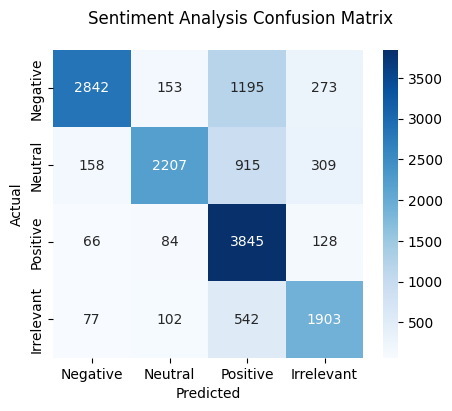

In [133]:
confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive', 'Irrelevant'], yticklabels=['Negative', 'Neutral', 'Positive', 'Irrelevant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.suptitle('Sentiment Analysis Confusion Matrix')
plt.show()

In [135]:
classification_rep = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant'])
print(classification_rep)

              precision    recall  f1-score   support

    Negative       0.90      0.64      0.75      4463
     Neutral       0.87      0.61      0.72      3589
    Positive       0.59      0.93      0.72      4123
  Irrelevant       0.73      0.73      0.73      2624

    accuracy                           0.73     14799
   macro avg       0.77      0.73      0.73     14799
weighted avg       0.78      0.73      0.73     14799

